In [1]:
import numpy as np
import pandas as pd
import darts
from darts import TimeSeries
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
#import seaborn as sns
from datetime import datetime
from darts.dataprocessing.transformers import Scaler
from darts.metrics import smape, r2_score, rmse

from darts.models import (
    AutoARIMA,
    Prophet,
    RNNModel,
    NBEATSModel,
    BlockRNNModel,
    VARIMA,
)

In [31]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
display(df.sample(10))
df = pd.concat([df.drop(columns='StateHoliday'), pd.get_dummies(df.StateHoliday, prefix='Holiday')], axis=1)

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday
121491,1072,2,2015-04-14,9419,774,1,1,0,0
1009927,523,1,2013-01-07,21854,2464,1,1,0,0
584055,581,5,2014-01-24,6106,610,1,1,0,0
642138,684,2,2013-12-03,10349,692,1,1,0,0
308863,583,3,2014-10-15,3944,428,1,0,0,0
791982,3,7,2013-07-21,0,0,0,0,0,0
425011,982,1,2014-06-16,14093,1011,1,1,0,0
349869,422,1,2014-09-01,5937,581,1,1,0,0
531707,638,3,2014-03-12,4499,387,1,0,0,0
594365,856,3,2014-01-15,5153,779,1,0,0,0


In [3]:
def get_sample(num):
    sample = df[df.Store == num]
    series = TimeSeries.from_dataframe(sample, 'Date', 'Sales')

    train, val = series.split_before(pd.Timestamp("20150101"))
    val, test = val.split_before(pd.Timestamp("20150601"))

    transformer = Scaler()
    train_transformed = transformer.fit_transform(train)
    val_transformed = transformer.transform(val)
    test_transformed = transformer.transform(test)

    series_customers = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Customers')
    series_open = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Open')
    series_promo = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Promo')
    series_school = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='SchoolHoliday')
    series_weekday = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='DayOfWeek')
    series_holiday_a = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_a')
    series_holiday_b = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_b')
    series_holiday_c = TimeSeries.from_dataframe(sample, time_col='Date', value_cols='Holiday_c')

    customers_transformed = transformer.transform(series_customers)

    covariates = series_customers.stack(series_open)
    covariates = covariates.stack(series_promo)
    covariates = covariates.stack(series_school)
    covariates = covariates.stack(series_weekday)
    covariates = covariates.stack(series_holiday_a)
    covariates = covariates.stack(series_holiday_b)
    covariates = covariates.stack(series_holiday_c)

    train_covariates, val_covariates = covariates.split_before(pd.Timestamp("20150101"))
    val_covariates, test_covariates = val_covariates.split_before(pd.Timestamp("20150601"))

    return train_transformed, val_transformed, test_transformed, covariates, customers_transformed

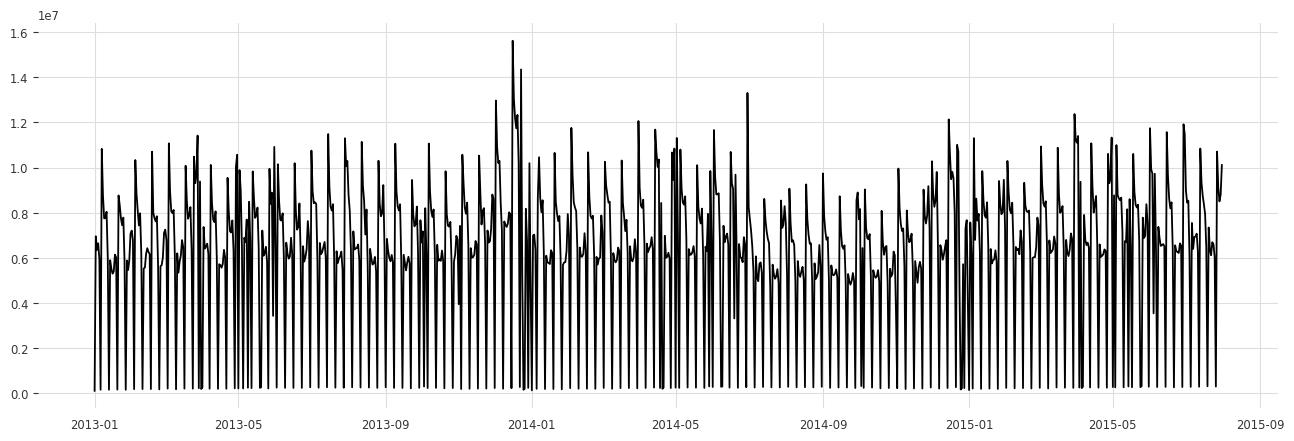

In [26]:
import seaborn as sns 
plt.figure(figsize=(16,5))
sample = df.groupby('Date').sum().reset_index()
plt.plot(sample['Date'], sample['Sales'])

Text(0, 0.5, '# of Open')

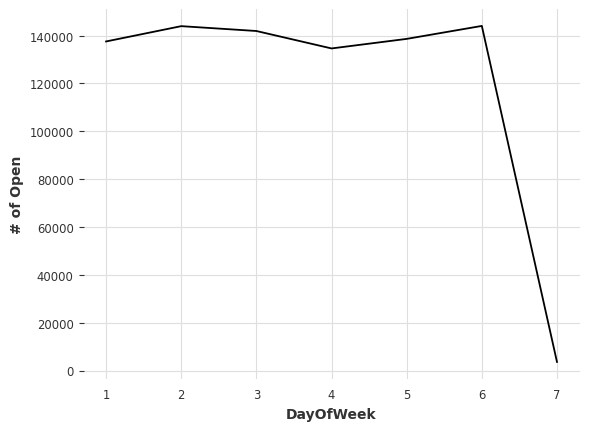

In [30]:
dfdow = df.groupby('DayOfWeek').sum().reset_index()
plt.plot(dfdow['DayOfWeek'], dfdow['Open'])
plt.xlabel('DayOfWeek')
plt.ylabel('# of Open')

In [35]:
df = pd.read_csv('../input/rossmann-store-sales/train.csv', parse_dates=['Date'])
df.groupby('StateHoliday').sum() / df.groupby('StateHoliday').count()

,Customers,Date,DayOfWeek,Open,Promo,Sales,SchoolHoliday,Store
StateHoliday,,,,,,,,
0,642.176125,NaN,3.974480,0.855560,0.378593,5733.530624,0.229553,558.767609
0,653.298069,NaN,4.023616,0.855284,0.383190,5980.279717,0.159191,558.342217
a,43.817670,NaN,3.424136,0.034255,0.367769,290.735686,0.256910,559.931343
b,36.561883,NaN,3.000000,0.021674,0.500000,214.311510,0.927653,558.000000
c,27.174390,NaN,3.956098,0.017317,0.000000,168.733171,1.000000,559.160000


In [36]:
df.groupby('SchoolHoliday').sum() / df.groupby('SchoolHoliday').count()

,Customers,Date,DayOfWeek,Open,Promo,Sales,StateHoliday,Store
SchoolHoliday,,,,,,,,
0,617.645174,NaN,4.189665,0.815015,0.366227,5620.979034,NaN,558.333533
1,704.412941,NaN,3.118698,0.899494,0.451802,6476.522207,NaN,558.871991


In [4]:
train_transformed, val_transformed, test_transformed, covariates, customers_transformed = get_sample(1)

In [9]:
sample

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,SchoolHoliday,Holiday_0,Holiday_0,Holiday_a,Holiday_b,Holiday_c
0,1,5,2015-07-31,5263,555,1,1,1,0,1,0,0,0
1115,1,4,2015-07-30,5020,546,1,1,1,0,1,0,0,0
2230,1,3,2015-07-29,4782,523,1,1,1,0,1,0,0,0
3345,1,2,2015-07-28,5011,560,1,1,1,0,1,0,0,0
4460,1,1,2015-07-27,6102,612,1,1,1,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
1011635,1,6,2013-01-05,4997,635,1,0,1,0,1,0,0,0
1012750,1,5,2013-01-04,4486,619,1,0,1,0,1,0,0,0
1013865,1,4,2013-01-03,4327,578,1,0,1,0,1,0,0,0
1014980,1,3,2013-01-02,5530,668,1,0,1,0,1,0,0,0


In [5]:
auto_arima = AutoARIMA()
auto_arima.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = auto_arima.predict(len(val_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('AutoARIMA')
print("sMAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('AutoARIMA')

KeyboardInterrupt: 

10:26:14 - cmdstanpy - INFO - Chain [1] start processing
10:26:14 - cmdstanpy - INFO - Chain [1] done processing


PROPHET
sMAPE: 41.279755671144535
RMSE: 0.028395831024631984


Text(0.5, 1.0, 'PROPHET')

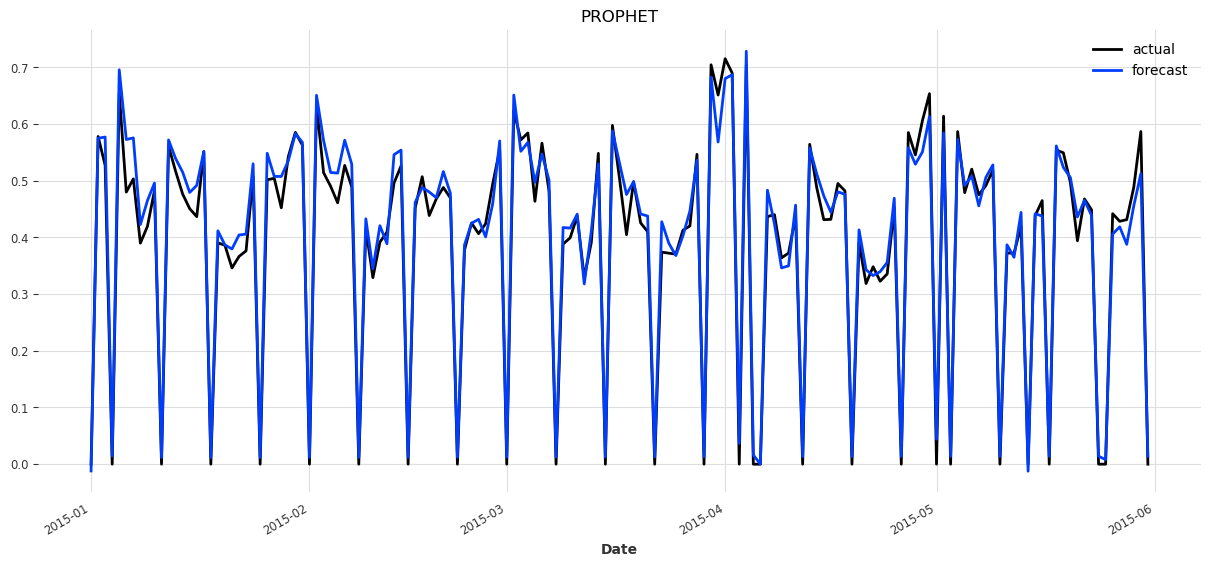

In [52]:
prophet = Prophet()
prophet.fit(train_transformed, future_covariates=covariates)
pred_demand_covs = prophet.predict(len(val_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")

print('PROPHET')
print("sMAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('PROPHET')

In [53]:
from pytorch_lightning.callbacks.early_stopping import EarlyStopping

my_stopper = EarlyStopping(
    monitor="train_loss",
    patience=5,
    min_delta=0.05,
    mode='min',
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | LSTM             | 4.9 K 
4 | V             | Linear           | 31    
---------------------------------------------------
5.0 K     Trainable params
0         Non-trainable params
5.0 K     Total params
0.040     Total estimated model params size (MB)


Sanity Checking: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
Trainer already configured with model summary callbacks: [<class 'pytorch_lightning.callbacks.model_summary.ModelSummary'>]. Skipping setting a default `ModelSummary` callback.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

RNNModel
MAPE: 41.180791579950295
RMSE: 0.026538100771396525


Text(0.5, 1.0, 'RNNModel')

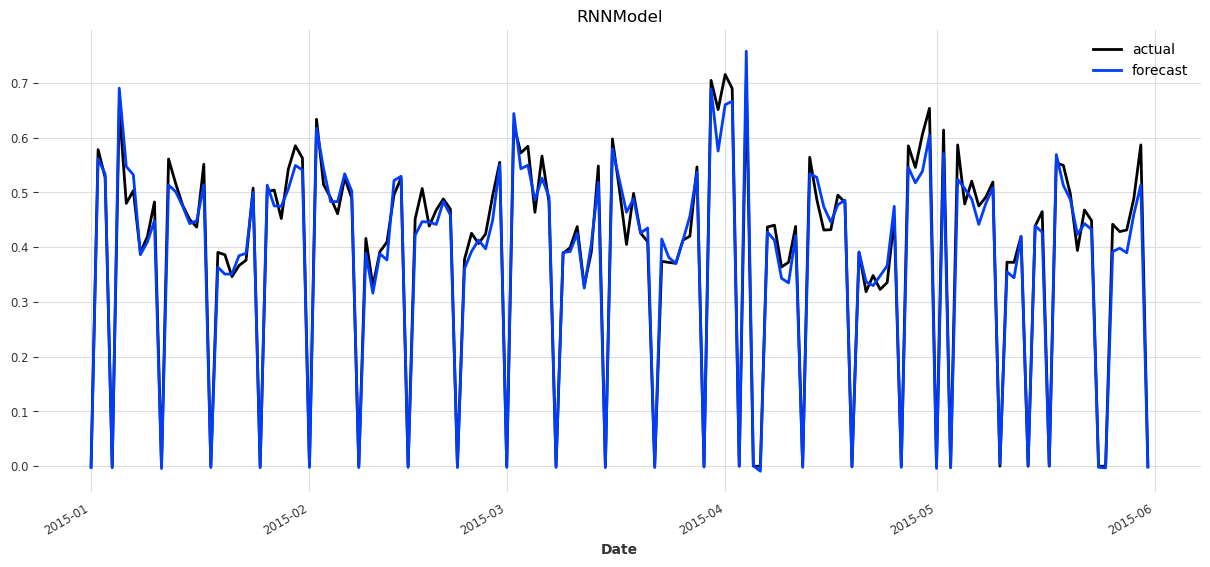

In [68]:
rnn_model = RNNModel(
    model="LSTM",
    hidden_dim=30,
    dropout=0.3,
    batch_size=16,
    n_epochs=200,
    optimizer_kwargs={"lr": 1e-3},
    model_name="rnn_sales",
    random_state=42,
    training_length=30,
    input_chunk_length=28,
    force_reset=True,
    save_checkpoints=True,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

rnn_model.fit(
    train_transformed,
    future_covariates=covariates,
    val_series=val_transformed,
    val_future_covariates=covariates,
    verbose=False,
)

pred_demand_covs = rnn_model.predict(len(val_transformed), future_covariates=covariates)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('RNNModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('RNNModel')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

NBEATSModel
MAPE: 53.25438430878595
RMSE: 0.14025745312473556


Text(0.5, 1.0, 'NBEATSModel')

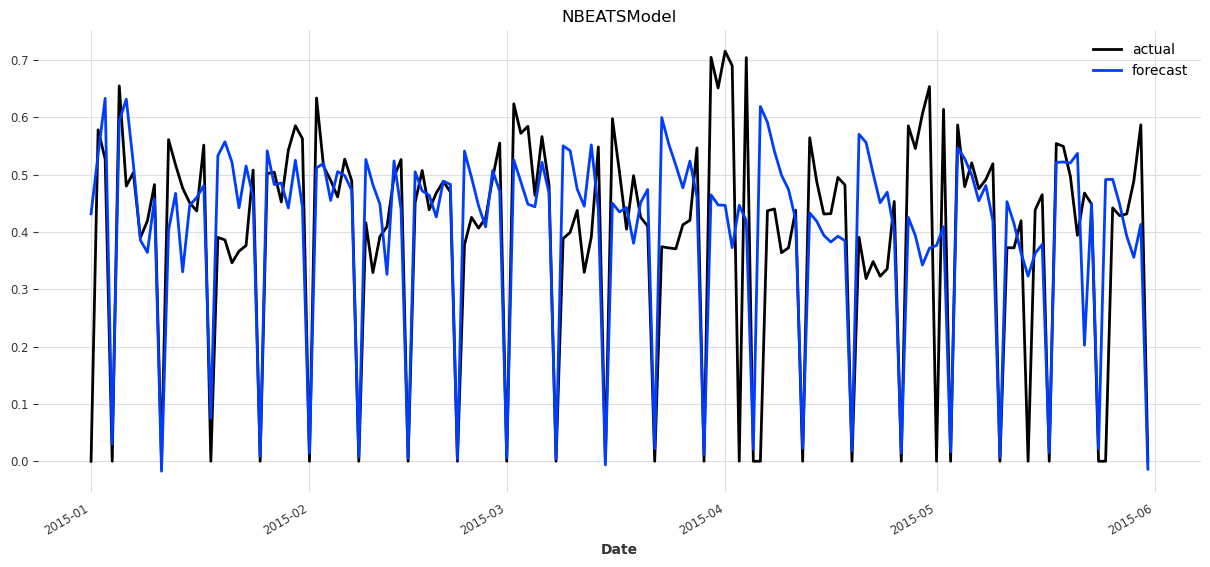

In [69]:
nbeats_model = NBEATSModel(
    input_chunk_length=30,
    output_chunk_length=7,
    n_epochs=200,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

train_customers_transformed, _ = customers_transformed.split_before(pd.Timestamp("20150101"))
train_covariates, _ = covariates.split_before(pd.Timestamp("20150101"))

nbeats_model.fit(series=[train_transformed, train_customers_transformed], verbose=False)
pred_demand_covs = nbeats_model.predict(len(val_transformed), series=train_transformed)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('NBEATSModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('NBEATSModel')

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type             | Params
---------------------------------------------------
0 | criterion     | MSELoss          | 0     
1 | train_metrics | MetricCollection | 0     
2 | val_metrics   | MetricCollection | 0     
3 | rnn           | RNN              | 2.0 K 
4 | fc            | Sequential       | 182   
---------------------------------------------------
2.2 K     Trainable params
0         Non-trainable params
2.2 K     Total params
0.017     Total estimated model params size (MB)


Training: 0it [00:00, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting: 0it [00:00, ?it/s]

BlockRNNModel
MAPE: 61.07945390662156
RMSE: 0.20011848249224895


Text(0.5, 1.0, 'BlockRNNModel')

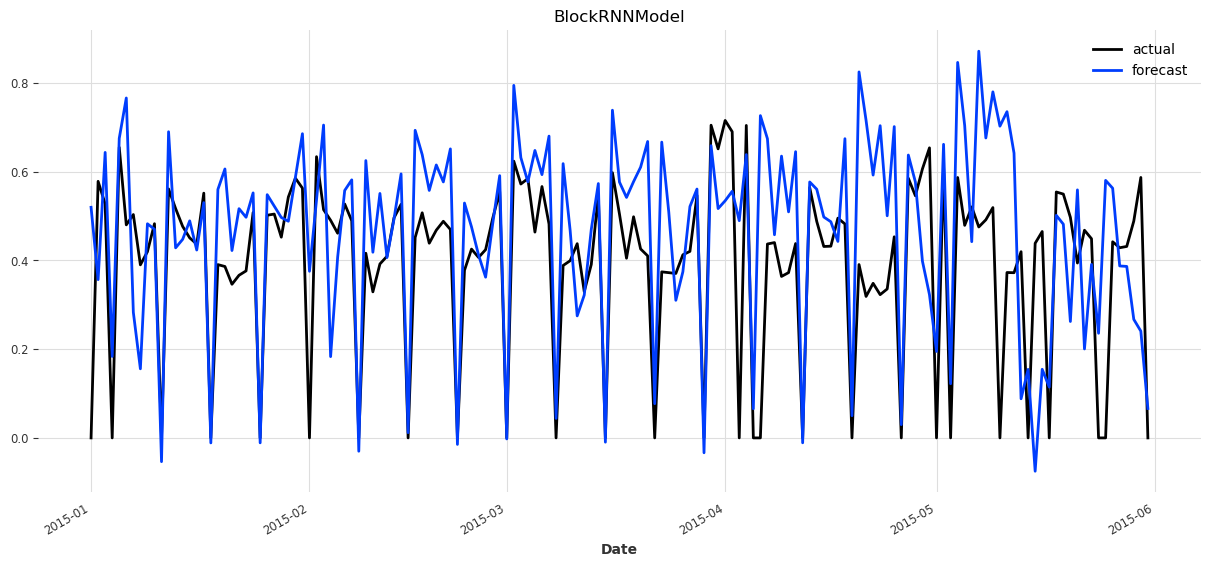

In [70]:
brnn_model = BlockRNNModel(
    input_chunk_length=30,
    output_chunk_length=7,
    n_rnn_layers=2,
    n_epochs=200,
    pl_trainer_kwargs ={"accelerator": "gpu", "devices": [0]}
)

train_customers_transformed, _ = customers_transformed.split_before(pd.Timestamp("20150101"))
train_covariates, _ = covariates.split_before(pd.Timestamp("20150101"))

brnn_model.fit(series=[train_transformed, train_customers_transformed], verbose=True)
pred_demand_covs = brnn_model.predict(len(val_transformed), series=train_transformed)

plt.figure(figsize=(15, 6))
val_transformed.plot(label="actual")
pred_demand_covs.plot(label="forecast")
print('BlockRNNModel')
print("MAPE: {}".format(smape(pred_demand_covs, val_transformed)))
print("RMSE: {}".format(rmse(val_transformed, pred_demand_covs)))
plt.title('BlockRNNModel')